# 1 Author

**Student Name**:  Zhu Lifeng  
**Student ID**:  230198823

# 2 Problem formulation
Use machine learning to predict the health rate of a dish.
It's an interesting problem for serval reasons:  
1) Health rate seens to be a somehow personally judgement, but it carries some common idea of humanity. So, I think it's a half objective half personal problem, which is interesting to dig in.  
2) It's an Ordered category prediction problem. which I think is a mixture of classification and regression, so almost all kinds of methods can be tried to be applied.  
3) If this project turns out to be working well, it may approve that the common idea of how healthy a dish is really exists (at least exists in our class).

# 3 Machine Learning pipeline
**first input**: the original input contains a list of its Diet, Cuision, Dish_name, Home_or_restaurant, Ingredients, Likeness and the label——Healthiness_rating, combined with the picture of it.  
**transformation**:  
the input table will be firstly cleanned, eliminating formatting and missing value issues whenever possible  
the Diet will be ordinalencoded
then the Cuision, Dish_name & Ingredients will be fixed and extracted into word frequency statistics, they will be operated by PCA after that for dimensionality reduction  
the picture will also be extracted into eight features  
all the prepared data will sequentially normalized, combined together and sent to the model  
**models**: a neural network model with 1 input layer, 3 hidden layers and 1 output layer  
**assess**: as an Ordered category prediction problem, I assess the model with the mean difference value, the median difference value, and the probability that the prediction landed in the range (the true value-1, the true value+1).  
(the label is ecoded into[1,2,3,4,5] in the order of the healthiness)

In [ ]:
pip install mlend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.8 MB/s eta 0:00:00


In [ ]:
pip install mlend --upgrade

In [ ]:
pip install tensorflow

In [ ]:
import mlend
from mlend import download_yummy, yummy_load
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spkit as sp

from skimage import exposure
from skimage.color import rgb2hsv, rgb2gray
import skimage as ski

import mlend
from mlend import download_yummy, yummy_load

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
datadir = download_yummy(save_to = '/MLEnd', subset = subset,verbose=1,overwrite=False)

# 7 Dataset
The dataset I use is the MLEnd Yummy Dataset. It will be splitted into TrainSet,ValSet and TestSet in the following Transformation stage.

In [ ]:
df= pd.read_csv('/content/drive/MyDrive/Data/MLEnd/yummy/MLEndYD_image_attributes_benchmark.csv')
df=df[['Diet','Cuisine','Dish_name','Home_or_restaurant','Ingredients','Healthiness_rating_int','Likeness_int','Benchmark_A']]
df

,Diet,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating_int,Likeness_int,Benchmark_A
0,non_vegetarian,japanese,chicken_katsu_rice,marugame_udon,"rice,chicken_breast,spicy_curry_sauce",3.0,4.0,Train
1,non_vegetarian,english,english_breakfast,home,"eggs,bacon,hash_brown,tomato,bread,tomato,bake...",2.0,4.0,Train
2,non_vegetarian,chinese,spicy_chicken,jinli_flagship_branch,"chili,chicken,peanuts,sihuan_peppercorns,green...",3.0,5.0,Train
3,vegetarian,indian,gulab_jamun,home,"sugar,water,khoya,milk,salt,oil,cardamon,ghee",2.0,5.0,Train
4,non_vegetarian,indian,chicken_masala,home,"chicken,lemon,turmeric,garam_masala,coriander_...",4.0,5.0,Train
...,...,...,...,...,...,...,...,...
3245,vegetarian,indian,zeera_rice,home,"1_cup_basmati_rice,2_cups_water,2_tablespoons_...",4.0,5.0,Train
3246,vegetarian,indian,paneer_and_dal,home,"fried_cottage_cheese,ghee,lentils,milk,wheat_f...",4.0,5.0,Test
3247,vegetarian,indian,samosa,home,"potato,onion,peanut,salt,turmeric_powder,red_c...",1.0,4.0,Test
3248,vegan,indian,fruit_milk,home,"kiwi,banana,apple,milk",5.0,5.0,Train


In [ ]:
sample_path = '/content/drive/MyDrive/Data/MLEnd/yummy/MLEndYD_images/*.jpg'
files = glob.glob(sample_path)

In [ ]:
df['file_path']=files
df

,Diet,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating_int,Likeness_int,Benchmark_A,file_path
0,non_vegetarian,japanese,chicken_katsu_rice,marugame_udon,"rice,chicken_breast,spicy_curry_sauce",3.0,4.0,Train,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...
1,non_vegetarian,english,english_breakfast,home,"eggs,bacon,hash_brown,tomato,bread,tomato,bake...",2.0,4.0,Train,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...
2,non_vegetarian,chinese,spicy_chicken,jinli_flagship_branch,"chili,chicken,peanuts,sihuan_peppercorns,green...",3.0,5.0,Train,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...
3,vegetarian,indian,gulab_jamun,home,"sugar,water,khoya,milk,salt,oil,cardamon,ghee",2.0,5.0,Train,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...
4,non_vegetarian,indian,chicken_masala,home,"chicken,lemon,turmeric,garam_masala,coriander_...",4.0,5.0,Train,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...
...,...,...,...,...,...,...,...,...,...
3245,vegetarian,indian,zeera_rice,home,"1_cup_basmati_rice,2_cups_water,2_tablespoons_...",4.0,5.0,Train,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...
3246,vegetarian,indian,paneer_and_dal,home,"fried_cottage_cheese,ghee,lentils,milk,wheat_f...",4.0,5.0,Test,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...
3247,vegetarian,indian,samosa,home,"potato,onion,peanut,salt,turmeric_powder,red_c...",1.0,4.0,Test,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...
3248,vegan,indian,fruit_milk,home,"kiwi,banana,apple,milk",5.0,5.0,Train,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...


# 4 Transformation stage
**1)** Given that there are only 9 samples contains missing value, I choose to delete them.  

In [ ]:
for i in df['file_path']:
    if df[df['file_path']==i].isnull().sum().any()>0:
        df.drop(df[df['file_path']==i].index,inplace=True)
df.reset_index(drop=True, inplace=True)
df

,Diet,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating_int,Likeness_int,Benchmark_A,file_path
0,non_vegetarian,japanese,chicken_katsu_rice,marugame_udon,"rice,chicken_breast,spicy_curry_sauce",3.0,4.0,Train,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...
1,non_vegetarian,english,english_breakfast,home,"eggs,bacon,hash_brown,tomato,bread,tomato,bake...",2.0,4.0,Train,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...
2,non_vegetarian,chinese,spicy_chicken,jinli_flagship_branch,"chili,chicken,peanuts,sihuan_peppercorns,green...",3.0,5.0,Train,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...
3,vegetarian,indian,gulab_jamun,home,"sugar,water,khoya,milk,salt,oil,cardamon,ghee",2.0,5.0,Train,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...
4,non_vegetarian,indian,chicken_masala,home,"chicken,lemon,turmeric,garam_masala,coriander_...",4.0,5.0,Train,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...
...,...,...,...,...,...,...,...,...,...
3236,vegetarian,indian,zeera_rice,home,"1_cup_basmati_rice,2_cups_water,2_tablespoons_...",4.0,5.0,Train,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...
3237,vegetarian,indian,paneer_and_dal,home,"fried_cottage_cheese,ghee,lentils,milk,wheat_f...",4.0,5.0,Test,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...
3238,vegetarian,indian,samosa,home,"potato,onion,peanut,salt,turmeric_powder,red_c...",1.0,4.0,Test,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...
3239,vegan,indian,fruit_milk,home,"kiwi,banana,apple,milk",5.0,5.0,Train,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...



**2)** For the label——Healthiness Rating, all samples carrying a label other than [1,2,3,4,5] is deleted.(didn't find any in this case though)  

In [ ]:
df=df[df['Healthiness_rating_int'].isin([1.0,2.0,3.0,4.0,5.0])]
df

,Diet,Cuisine,Dish_name,Home_or_restaurant,Ingredients,Healthiness_rating_int,Likeness_int,Benchmark_A,file_path
0,non_vegetarian,japanese,chicken_katsu_rice,marugame_udon,"rice,chicken_breast,spicy_curry_sauce",3.0,4.0,Train,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...
1,non_vegetarian,english,english_breakfast,home,"eggs,bacon,hash_brown,tomato,bread,tomato,bake...",2.0,4.0,Train,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...
2,non_vegetarian,chinese,spicy_chicken,jinli_flagship_branch,"chili,chicken,peanuts,sihuan_peppercorns,green...",3.0,5.0,Train,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...
3,vegetarian,indian,gulab_jamun,home,"sugar,water,khoya,milk,salt,oil,cardamon,ghee",2.0,5.0,Train,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...
4,non_vegetarian,indian,chicken_masala,home,"chicken,lemon,turmeric,garam_masala,coriander_...",4.0,5.0,Train,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...
...,...,...,...,...,...,...,...,...,...
3236,vegetarian,indian,zeera_rice,home,"1_cup_basmati_rice,2_cups_water,2_tablespoons_...",4.0,5.0,Train,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...
3237,vegetarian,indian,paneer_and_dal,home,"fried_cottage_cheese,ghee,lentils,milk,wheat_f...",4.0,5.0,Test,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...
3238,vegetarian,indian,samosa,home,"potato,onion,peanut,salt,turmeric_powder,red_c...",1.0,4.0,Test,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...
3239,vegan,indian,fruit_milk,home,"kiwi,banana,apple,milk",5.0,5.0,Train,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...



**3)** The Dish, Ingredients, Cuision will be fixed by deleting the meaningless characters(like punctuations other than the separator, "a", "an" and numbers)  
They will then be extracted into word frequency statistics.  

In [ ]:
df_name=pd.DataFrame(df['Dish_name'],columns=['Dish_name'])
for x in ['(', ')', '&', '-', '"',"'", '\\', r'/', 'a', 'an', ',', ':']:
    df_name['Dish_name']=df_name['Dish_name'].str.replace(x,'_',regex=False)
df_name['Dish_name']=df_name['Dish_name'].str.replace(r'\d','',regex=True)
df_name=df_name['Dish_name'].str.get_dummies('_')
df_name=df_name.add_prefix('Name_')

df_ingredients=pd.DataFrame(df['Ingredients'],columns=['Ingredients'])
for x in ['(',')','&','-', '"',"'",r'\"',r'\'',r'\\','/','a_','an_',':','_','.']:
    df_ingredients['Ingredients']=df_ingredients['Ingredients'].str.replace(x,'',regex=False)
df_ingredients['Ingredients']=df_ingredients['Ingredients'].str.replace(r'\d','',regex=True)
df_ingredients=df_ingredients['Ingredients'].str.get_dummies(',')
df_ingredients=df_ingredients.add_prefix('Ingredients_')

(df_name.shape,df_ingredients.shape)

((3241, 1388), (3241, 3307))


**4)** The Diet will be ordinalencoded by the order ['non_vegetarian','vegetarian','vegan']  
The Home_or_restaurant will be fixed(lots of restaurant names here, so every thing other than 'home' or 'restaurant' will be classified as 'restauant') and encoded.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
Diet_order=['non_vegetarian','vegetarian','vegan']
dfO=df[['Diet','Likeness_int']]
dfO['Home_or_restaurant']=df['Home_or_restaurant'].apply(lambda x: 'restaurant' if x != 'home' and x != 'restaurant' else x)
dfO['Home_or_restaurant']=dfO['Home_or_restaurant'].map({'home': 0, 'restaurant': 1})
df_Cuisine=df['Cuisine'].str.replace('and','').str.get_dummies('_')
df_Cuisine=df_Cuisine.add_prefix('Cuisine_')
df_OF=pd.concat([dfO.reset_index(drop=True),df_Cuisine.reset_index(drop=True)],axis=1)
df_OF['Diet']=OrdinalEncoder(categories=[Diet_order]).fit_transform(df_OF[['Diet']])

<ipython-input-14-45382ee16c31>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-14-45382ee16c31>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


**5)**dataset will be splitted into TrainSet, ValSet and TestSet and all the following operations will be based on the parameters produced by the TrainSet.    
Beacuse the former operation needs to be implemented on a completed dataset.  

In [ ]:
df=df[['Healthiness_rating_int','Likeness_int','file_path','Benchmark_A']]
df=pd.concat([df,df_OF,df_name,df_ingredients], axis=1,ignore_index=False)
df

,Healthiness_rating_int,Likeness_int,file_path,Benchmark_A,Diet,Likeness_int,Home_or_restaurant,Cuisine_afghan,Cuisine_african,Cuisine_american,...,Ingredients_yogurtcurd,Ingredients_yogurtoptional,Ingredients_yogurtsauce,Ingredients_yogurtsauces,Ingredients_yorkshirepudding,Ingredients_yougurt,Ingredients_yougurtsauce,Ingredients_yuba,Ingredients_yukongoldpotatoes,Ingredients_zucchini
0,3.0,4.0,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...,Train,0.0,4.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.0,4.0,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...,Train,0.0,4.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.0,5.0,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...,Train,0.0,5.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2.0,5.0,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...,Train,1.0,5.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.0,5.0,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...,Train,0.0,5.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3236,4.0,5.0,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...,Train,1.0,5.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3237,4.0,5.0,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...,Test,1.0,5.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3238,1.0,4.0,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...,Test,1.0,4.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3239,5.0,5.0,/content/drive/MyDrive/Data/MLEnd/yummy/MLEndY...,Train,2.0,5.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split
TrainSet=df[df['Benchmark_A']=='Train']
TestSet=df[df['Benchmark_A']=='Test']

STrainSet,ValSet=train_test_split(TrainSet,test_size=0.2,stratify=TrainSet['Healthiness_rating_int'])

(TrainSet.shape,STrainSet.shape,ValSet.shape,TestSet.shape)

((2268, 4819), (1814, 4819), (454, 4819), (973, 4819))

In [ ]:
X_train_paths=TrainSet['file_path']
X_train_name=TrainSet.filter(like='Name_')
X_train_ingredients=TrainSet.filter(like='Ingredients_')
X_train_Cuisine=TrainSet.filter(like='Cuisine_')
X_train_O=TrainSet[['Diet','Home_or_restaurant','Likeness_int']]
Y_train=TrainSet['Healthiness_rating_int']

X_strain_paths=STrainSet['file_path']
X_strain_name=STrainSet.filter(like='Name_')
X_strain_ingredients=STrainSet.filter(like='Ingredients_')
X_strain_Cuisine=STrainSet.filter(like='Cuisine_')
X_strain_O=STrainSet[['Diet','Home_or_restaurant','Likeness_int']]
Y_strain=STrainSet['Healthiness_rating_int']

X_val_paths=ValSet['file_path']
X_val_name=ValSet.filter(like='Name_')
X_val_ingredients=ValSet.filter(like='Ingredients_')
X_val_Cuisine=ValSet.filter(like='Cuisine_')
X_val_O=ValSet[['Diet','Home_or_restaurant','Likeness_int']]
Y_val=ValSet['Healthiness_rating_int']

X_test_paths=TestSet['file_path']
X_test_name=TestSet.filter(like='Name_')
X_test_ingredients=TestSet.filter(like='Ingredients_')
X_test_Cuisine=TestSet.filter(like='Cuisine_')
X_test_O=TestSet[['Diet','Home_or_restaurant','Likeness_int']]
Y_test=TestSet['Healthiness_rating_int']

print(X_train_paths.shape,X_train_name.shape,X_train_ingredients.shape,X_train_Cuisine.shape,X_train_O.shape,Y_train.shape)
print(X_strain_paths.shape,X_strain_name.shape,X_strain_ingredients.shape,X_strain_Cuisine.shape,X_strain_O.shape,Y_strain.shape)
print(X_val_paths.shape,X_val_name.shape,X_val_ingredients.shape,X_val_Cuisine.shape,X_val_O.shape,Y_val.shape)
print(X_test_paths.shape,X_test_name.shape,X_test_ingredients.shape,X_test_Cuisine.shape,X_test_O.shape,Y_test.shape)

(2268,) (2268, 1388) (2268, 3307) (2268, 117) (2268, 4) (2268,)
(1814,) (1814, 1388) (1814, 3307) (1814, 117) (1814, 4) (1814,)
(454,) (454, 1388) (454, 3307) (454, 117) (454, 4) (454,)
(973,) (973, 1388) (973, 3307) (973, 117) (973, 4) (973,)



**6)** The Dish, Ingredients, Cuision will be respectively processed by PCA and only the high value features will be kept(in this case I kept basically 80% of the feature information)  

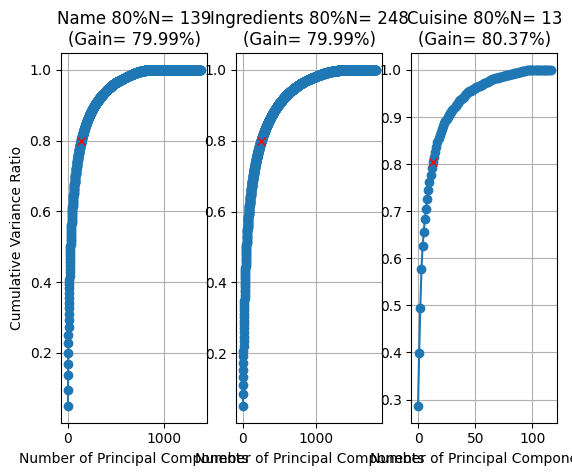

In [ ]:
from sklearn.decomposition import PCA
pcaNT=PCA()
pcaNT.fit(X_strain_name)
cumulative_variance_ratio = pcaNT.explained_variance_ratio_.cumsum()
nsNT=0
niNT=0
for i,value in enumerate(cumulative_variance_ratio):
    if abs(value-0.8)<abs(nsNT-0.8):
        nsNT=value
        niNT=i
nearestNT=cumulative_variance_ratio[niNT]*100


ax1=plt.subplot(131)
ax1.plot(cumulative_variance_ratio, marker='o')
ax1.plot(niNT,nearestNT/100,marker='x',c='r')
ax1.set_xlabel('Number of Principal Components')
ax1.set_ylabel('Cumulative Variance Ratio')
ax1.set_title('Name 80%N= '+str(niNT)+f'\n(Gain= {nearestNT:.2f}%)')
ax1.grid(True)

pcaIT=PCA()
pcaIT.fit(X_strain_ingredients)
cumulative_variance_ratio = pcaIT.explained_variance_ratio_.cumsum()
nsIT=0
niIT=0
for i,value in enumerate(cumulative_variance_ratio):
    if abs(value-0.8)<abs(nsIT-0.8):
        nsIT=value
        niIT=i
nearestIT=cumulative_variance_ratio[niIT]*100
ax2=plt.subplot(132)
ax2.plot(cumulative_variance_ratio, marker='o')
ax2.plot(niIT,nearestIT/100,marker='x',c='r')
ax2.set_xlabel('Number of Principal Components')
ax2.set_title('Ingredients 80%N= '+str(niIT)+f'\n(Gain= {nearestIT:.2f}%)')
ax2.grid(True)

pcaCT=PCA()
pcaCT.fit(X_strain_Cuisine)
cumulative_variance_ratio = pcaCT.explained_variance_ratio_.cumsum()
nsCT=0
niCT=0
for i,value in enumerate(cumulative_variance_ratio):
    if abs(value-0.8)<abs(nsCT-0.8):
        nsCT=value
        niCT=i
nearestCT=cumulative_variance_ratio[niCT]*100
ax3=plt.subplot(133)
ax3.plot(cumulative_variance_ratio, marker='o')
ax3.plot(niCT,nearestCT/100,marker='x',c='r')
ax3.set_xlabel('Number of Principal Components')
ax3.set_title('Cuisine 80%N= '+str(niCT)+f'\n(Gain= {nearestCT:.2f}%)')
ax3.grid(True)

In [ ]:
pca=PCA(niNT)
pca.fit(X_strain_name)
X_strain_pca_name = pd.DataFrame(pca.fit_transform(X_strain_name), columns=[f'Name_{i}' for i in range(1,niNT+1)])
X_train_pca_name = pd.DataFrame(pca.fit_transform(X_train_name), columns=[f'Name_{i}' for i in range(1,niNT+1)])
X_val_pca_name = pd.DataFrame(pca.fit_transform(X_val_name), columns=[f'Name_{i}' for i in range(1,niNT+1)])
X_test_pca_name = pd.DataFrame(pca.fit_transform(X_test_name), columns=[f'Name_{i}' for i in range(1,niNT+1)])



pca=PCA(niIT)
pca.fit(X_strain_ingredients)
X_strain_pca_ingredients = pd.DataFrame(pca.fit_transform(X_strain_ingredients), columns=[f'Ingredients_{i}' for i in range(1,niIT+1)])
X_train_pca_ingredients = pd.DataFrame(pca.fit_transform(X_train_ingredients), columns=[f'Ingredients_{i}' for i in range(1,niIT+1)])
X_val_pca_ingredients = pd.DataFrame(pca.fit_transform(X_val_ingredients), columns=[f'Ingredients_{i}' for i in range(1,niIT+1)])
X_test_pca_ingredients = pd.DataFrame(pca.fit_transform(X_test_ingredients), columns=[f'Ingredients_{i}' for i in range(1,niIT+1)])

pca=PCA(niCT)
pca.fit(X_strain_Cuisine)
X_strain_pca_Cuisine = pd.DataFrame(pca.fit_transform(X_strain_Cuisine), columns=[f'Cuisine_{i}' for i in range(1,niCT+1)])
X_train_pca_Cuisine = pd.DataFrame(pca.fit_transform(X_train_Cuisine), columns=[f'Cuisine_{i}' for i in range(1,niCT+1)])
X_val_pca_Cuisine = pd.DataFrame(pca.fit_transform(X_val_Cuisine), columns=[f'Cuisine_{i}' for i in range(1,niCT+1)])
X_test_pca_Cuisine = pd.DataFrame(pca.fit_transform(X_test_Cuisine), columns=[f'Cuisine_{i}' for i in range(1,niCT+1)])

print(X_train_paths.shape,X_train_pca_name.shape,X_train_pca_ingredients.shape,X_train_pca_Cuisine.shape,X_train_O.shape,Y_train.shape)
print(X_strain_paths.shape,X_strain_pca_name.shape,X_strain_pca_ingredients.shape,X_strain_pca_Cuisine.shape,X_strain_O.shape,Y_strain.shape)
print(X_val_paths.shape,X_val_pca_name.shape,X_val_pca_ingredients.shape,X_val_pca_Cuisine.shape,X_val_O.shape,Y_val.shape)
print(X_test_paths.shape,X_test_pca_name.shape,X_test_pca_ingredients.shape,X_test_pca_Cuisine.shape,X_test_O.shape,Y_test.shape)

(2268,) (2268, 139) (2268, 248) (2268, 13) (2268, 4) (2268,)
(1814,) (1814, 139) (1814, 248) (1814, 13) (1814, 4) (1814,)
(454,) (454, 139) (454, 248) (454, 13) (454, 4) (454,)
(973,) (973, 139) (973, 248) (973, 13) (973, 4) (973,)



**7)** The pictures will be read and extracted into the following eight features:  
1. yellow_component: the number of pixels that is basically yellow  
(the color of potato products and some fruits like bananas)  
2. red_component: the number of pixels that is basically red  
(the color of chili and some fruits like apples)
3. green_component: the number of pixels that is basically green  
(the color of most vegetable leaves)
4. orange_component: the number of pixels that is basically orange  
(the color of fried food)
5. light_component: the number of pixels that is extremely light  
(the brightness of food may point out some food type)
6. saturability component:the number of pixels whose saturability is extremely high  
(the saturability of food may point out some food type)
7.8 GMLC_features: 2 features containing the information of the texture of the picture  
(the image information other than color)  

In [ ]:
def data_preparation(img_path,fixed_size):
    I=plt.imread(img_path)
    N,M,C = I.shape
    Ir = [sp.core.processing.resize(I[:,:,i],fixed_size) for i in range(C)]
    I=np.array(Ir).transpose([1,2,0])
    return I

In [ ]:
from skimage.feature import ORB
from skimage.feature import graycomatrix, graycoprops
def get_yellow_component(I,t1=38, t2=51):
  Ihsv = (rgb2hsv(I)* 255).astype('uint8')
  mask = (Ihsv[:,:,0]<t2)&(Ihsv[:,:,0]>t1)
  Ypx = mask.sum()
  return Ypx

def get_red_component(I, t1=242, t2=13):
    Ihsv = (rgb2hsv(I)* 255).astype('uint8')
    mask = ((Ihsv[:, :, 0] >= t1) | (Ihsv[:, :, 0] <= t2))
    Rpx = mask.sum()
    return Rpx

def get_green_component(I, t1=51, t2=102):
    Ihsv = (rgb2hsv(I)* 255).astype('uint8')
    mask = (Ihsv[:, :, 0] >= t1) & (Ihsv[:, :, 0] <= t2)
    Gpx = mask.sum()
    return Gpx

def get_orange_component(I, t1=15, t2=36):
    Ihsv = (rgb2hsv(I) * 255).astype('uint8')
    mask = (Ihsv[:, :, 0] >= t1) & (Ihsv[:, :, 0] <= t2)
    Gpx = mask.sum()
    return Gpx

def get_light_component(I,t1=200,t2=255):
  Ihsv=(rgb2hsv(I)*255).astype('uint8')
  mask=(Ihsv[:,:,2]>=t1)&(Ihsv[:,:,2]<=t2)
  lpx=mask.sum()
  return lpx

def get_s_component(I,t1=200,t2=255):
  Ihsv=(rgb2hsv(I)*255).astype('uint8')
  mask=(Ihsv[:,:,1]>=t1)&(Ihsv[:,:,1]<=t2)
  spx=mask.sum()
  return spx

def GMLC_features(I):
  Ig = (rgb2gray(I)*255).astype('uint8')
  glcm = graycomatrix(Ig, distances=[5], angles=[0], levels=256,
                        symmetric=True, normed=True)
  f1 = graycoprops(glcm, 'dissimilarity')[0, 0]
  f2 = graycoprops(glcm, 'correlation')[0, 0]
  return f1,f2


def showConfMat(CM, labels = ['Chips','Rice']):
  plt.matshow(CM,cmap='Blues')
  for i in range(CM.shape[0]):
    for j in range(CM.shape[1]):
      plt.text(i,j,CM[i,j].round(2),ha='center',)
  plt.xticks([0,1],labels)
  plt.yticks([0,1],labels)
  plt.show()

In [ ]:
fixed_size=[200,200]
X_train_img = []
for k,file in enumerate(X_train_paths):
  sp.utils.ProgBar_JL(k,len(X_train_paths),L=50,color='blue')
  I = data_preparation(file,fixed_size)
  X_train_img.append(I)

X_val_img = []
for k,file in enumerate(X_val_paths):
  sp.utils.ProgBar_JL(k,len(X_val_paths),L=50,color='blue')
  I = data_preparation(file,fixed_size)
  X_val_img.append(I)

X_strain_img = []
for k,file in enumerate(X_strain_paths):
  sp.utils.ProgBar_JL(k,len(X_strain_paths),L=50,color='blue')
  I = data_preparation(file,fixed_size)
  X_strain_img.append(I)

X_test_img = []
for k,file in enumerate(X_test_paths):
  sp.utils.ProgBar_JL(k,len(X_test_paths),L=50,color='blue')
  I = data_preparation(file,fixed_size)
  X_test_img.append(I)


X_train_img = np.array(X_train_img)
X_strain_img = np.array(X_strain_img)
X_val_img = np.array(X_val_img)
X_test_img = np.array(X_test_img)

100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|2268\2268|
Done!
100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|454\454|
Done!
100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|1814\1814|
Done!
100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|973\973|
Done!


In [ ]:
X_train_imgF=[]
for k,I in enumerate(X_train_img):
    f1=get_yellow_component(I)
    f2=get_red_component(I)
    f3=get_green_component(I)
    f4=get_orange_component(I)
    f5=get_light_component(I)
    f6=get_s_component(I)
    f7,f8=GMLC_features(I)
    X_train_imgF.append([f1,f2,f3,f4,f5,f6,f7,f8])

X_strain_imgF=[]
for k,I in enumerate(X_strain_img):
    f1=get_yellow_component(I)
    f2=get_red_component(I)
    f3=get_green_component(I)
    f4=get_orange_component(I)
    f5=get_light_component(I)
    f6=get_s_component(I)
    f7,f8=GMLC_features(I)
    X_strain_imgF.append([f1,f2,f3,f4,f5,f6,f7,f8])

X_val_imgF=[]
for k,I in enumerate(X_val_img):
    f1=get_yellow_component(I)
    f2=get_red_component(I)
    f3=get_green_component(I)
    f4=get_orange_component(I)
    f5=get_light_component(I)
    f6=get_s_component(I)
    f7,f8=GMLC_features(I)
    X_val_imgF.append([f1,f2,f3,f4,f5,f6,f7,f8])

X_test_imgF=[]
for k,I in enumerate(X_test_img):
    f1=get_yellow_component(I)
    f2=get_red_component(I)
    f3=get_green_component(I)
    f4=get_orange_component(I)
    f5=get_light_component(I)
    f6=get_s_component(I)
    f7,f8=GMLC_features(I)
    X_test_imgF.append([f1,f2,f3,f4,f5,f6,f7,f8])

X_train_imgF=pd.DataFrame(X_train_imgF,columns=['img_f1','img_f2','img_f3','img_f4','img_f5','img_f6','img_f7','img_f8'])
X_strain_imgF=pd.DataFrame(X_strain_imgF,columns=['img_f1','img_f2','img_f3','img_f4','img_f5','img_f6','img_f7','img_f8'])
X_val_imgF=pd.DataFrame(X_val_imgF,columns=['img_f1','img_f2','img_f3','img_f4','img_f5','img_f6','img_f7','img_f8'])
X_test_imgF=pd.DataFrame(X_test_imgF,columns=['img_f1','img_f2','img_f3','img_f4','img_f5','img_f6','img_f7','img_f8'])

print(X_train_imgF.shape,X_train_pca_name.shape,X_train_pca_ingredients.shape,X_train_pca_Cuisine.shape,X_train_O.shape,Y_train.shape)
print(X_strain_imgF.shape,X_strain_pca_name.shape,X_strain_pca_ingredients.shape,X_strain_pca_Cuisine.shape,X_strain_O.shape,Y_strain.shape)
print(X_val_imgF.shape,X_val_pca_name.shape,X_val_pca_ingredients.shape,X_val_pca_Cuisine.shape,X_val_O.shape,Y_val.shape)
print(X_test_imgF.shape,X_test_pca_name.shape,X_test_pca_ingredients.shape,X_test_pca_Cuisine.shape,X_test_O.shape,Y_test.shape)

(2268, 8) (2268, 139) (2268, 248) (2268, 13) (2268, 4) (2268,)
(1814, 8) (1814, 139) (1814, 248) (1814, 13) (1814, 4) (1814,)
(454, 8) (454, 139) (454, 248) (454, 13) (454, 4) (454,)
(973, 8) (973, 139) (973, 248) (973, 13) (973, 4) (973,)



**8)** All the collected information above will be normalized at last.

In [ ]:
Mean_img=X_strain_imgF.mean(0)
SD_img=X_strain_imgF.std(0)
Mean_name=X_strain_pca_name.mean(0)
SD_name=X_strain_pca_name.std(0)
Mean_ingre=X_strain_pca_ingredients.mean(0)
SD_ingre=X_strain_pca_ingredients.std(0)
Mean_Cuisine=X_strain_pca_Cuisine.mean(0)
SD_Cuisine=X_strain_pca_Cuisine.std(0)
Mean_O=X_strain_O.mean(0)
SD_O=X_strain_O.std(0)

TX_train_imgF=(X_train_imgF-Mean_img)/SD_img
TX_strain_imgF=(X_strain_imgF-Mean_img)/SD_img
TX_val_imgF=(X_val_imgF-Mean_img)/SD_img
TX_test_imgF=(X_test_imgF-Mean_img)/SD_img

TX_train_pca_name=(X_train_pca_name-Mean_name)/SD_name
TX_strain_pca_name=(X_strain_pca_name-Mean_name)/SD_name
TX_val_pca_name=(X_val_pca_name-Mean_name)/SD_name
TX_test_pca_name=(X_test_pca_name-Mean_name)/SD_name

TX_train_pca_ingredients=(X_train_pca_ingredients-Mean_ingre)/SD_ingre
TX_strain_pca_ingredients=(X_strain_pca_ingredients-Mean_ingre)/SD_ingre
TX_val_pca_ingredients=(X_val_pca_ingredients-Mean_ingre)/SD_ingre
TX_test_pca_ingredients=(X_test_pca_ingredients-Mean_ingre)/SD_ingre

TX_train_pca_Cuisine=(X_train_pca_Cuisine-Mean_Cuisine)/SD_Cuisine
TX_strain_pca_Cuisine=(X_strain_pca_Cuisine-Mean_Cuisine)/SD_Cuisine
TX_val_pca_Cuisine=(X_val_pca_Cuisine-Mean_Cuisine)/SD_Cuisine
TX_test_pca_Cuisine=(X_test_pca_Cuisine-Mean_Cuisine)/SD_Cuisine

TX_train_O=(X_train_O-Mean_O)/SD_O
TX_strain_O=(X_strain_O-Mean_O)/SD_O
TX_val_O=(X_val_O-Mean_O)/SD_O
TX_test_O=(X_test_O-Mean_O)/SD_O

In [ ]:
TX_trainAll=pd.concat([TX_train_imgF.reset_index(drop=True),TX_train_pca_name.reset_index(drop=True),TX_train_pca_ingredients.reset_index(drop=True),TX_train_pca_Cuisine.reset_index(drop=True),TX_train_O.reset_index(drop=True)], axis=1,ignore_index=False)
TX_strainAll=pd.concat([TX_strain_imgF.reset_index(drop=True),TX_strain_pca_name.reset_index(drop=True),TX_strain_pca_ingredients.reset_index(drop=True),TX_strain_pca_Cuisine.reset_index(drop=True),TX_strain_O.reset_index(drop=True)], axis=1,ignore_index=False)
TX_valAll=pd.concat([TX_val_imgF.reset_index(drop=True),TX_val_pca_name.reset_index(drop=True),TX_val_pca_ingredients.reset_index(drop=True),TX_val_pca_Cuisine.reset_index(drop=True),TX_val_O.reset_index(drop=True)], axis=1,ignore_index=False)
TX_testAll=pd.concat([TX_test_imgF.reset_index(drop=True),TX_test_pca_name.reset_index(drop=True),TX_test_pca_ingredients.reset_index(drop=True),TX_test_pca_Cuisine.reset_index(drop=True),TX_test_O.reset_index(drop=True)], axis=1,ignore_index=False)

TX_trainAll.shape,TX_strainAll.shape,TX_valAll.shape,TX_testAll.shape

((2268, 412), (1814, 412), (454, 412), (973, 412))

# 5 Modelling
The Neural Network we use has 1 input layer (417 nodes), 3 hidden layer(2 with 64 nodes and the relu activation function, 1 with 10 nodes and softmax activation function), and a output layer with 1 node and linear activation function.  
This architecture basically treat the problem as a classification at first, and get a result to form a regression function, which combined the idea of classification and regression.
Given that we now get a much bigger database, the neural network can provide enough complexity to solve the problem. Besides, with its free architecture designment, it can combine the classification process and regression process together.

# 6 Methodology
The original dataset will be splitted into TrainSet and TestSet with the Benchmark_A, then the TrainSet will be randomly splitted into S-TrainSet(80%) and ValSet(20%).
The S-TrainSet will be used to trained the model while the ValSet will be used to validated it, and the model will be amended based on its performance. (the architecture mentioned above is the one after amending)  
After that this model will be tested with the TestSet by the mean difference value, the median difference value, and the probability that the prediction landed in the range (the true value-1, the true value+1).

# 8 Results

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(TX_strainAll.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.add(layers.Dense(1, activation='linear'))
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['mse'])
Val_data=(TX_valAll,Y_val)
early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
model.fit(TX_strainAll,Y_strain, epochs=1000, batch_size=10, validation_data=Val_data,callbacks=[early_stopping])

Epoch 1/1000
182/182 [==============================] - 4s 7ms/step - loss: 9.2846 - mse: 9.2846 - val_loss: 7.7037 - val_mse: 7.7037
Epoch 2/1000
182/182 [==============================] - 1s 4ms/step - loss: 6.8703 - mse: 6.8703 - val_loss: 6.0854 - val_mse: 6.0854
Epoch 3/1000
182/182 [==============================] - 1s 3ms/step - loss: 5.4251 - mse: 5.4251 - val_loss: 4.8027 - val_mse: 4.8027
Epoch 4/1000
182/182 [==============================] - 1s 4ms/step - loss: 4.2843 - mse: 4.2843 - val_loss: 3.7986 - val_mse: 3.7986
Epoch 5/1000
182/182 [==============================] - 1s 4ms/step - loss: 3.3964 - mse: 3.3964 - val_loss: 3.0212 - val_mse: 3.0212
Epoch 6/1000
182/182 [==============================] - 1s 4ms/step - loss: 2.7189 - mse: 2.7189 - val_loss: 2.4392 - val_mse: 2.4392
Epoch 7/1000
182/182 [==============================] - 1s 3ms/step - loss: 2.2120 - mse: 2.2120 - val_loss: 2.0062 - val_mse: 2.0062
Epoch 8/1000
182/182 [==============================] - 1s 3ms

15/15 [==============================] - 0s 3ms/step
mean= 0.04735070073131948
median= -0.40198850631713867
around_val_accuracy= 62.33480176211453 %


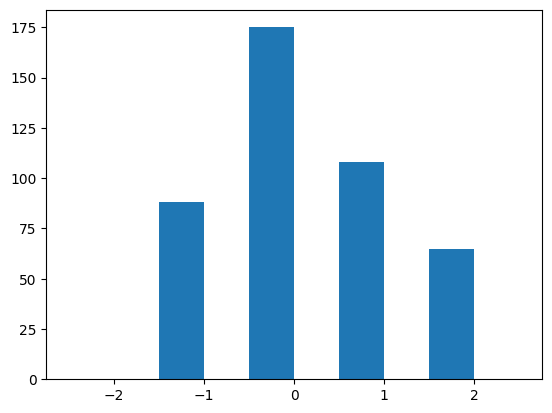

In [ ]:
Y_pre=model.predict(TX_valAll)
diff=Y_pre[0]-(Y_val)
val_accuracy=np.mean((diff<1) & (diff >-1))
print('mean=',np.mean(diff))
print('median=',np.median(diff))
print('around_val_accuracy=',val_accuracy*100,"%")
plt.hist(diff,density=False,bins=[-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5])
plt.show()

The mean and the median difference value is quite low. The probability the prediction landed near the true value is 62.33%, but according the histogram of difference, all of the prediction landed near the true value in a range of 2 and most of them landed near the true value in a range of 1.5, so the performance on the val set is acceptable for me now.

31/31 [==============================] - 1s 12ms/step
mean= 0.07139588088440381
median= -0.4034242630004883
around_val_accuracy= 64.95375128468653 %


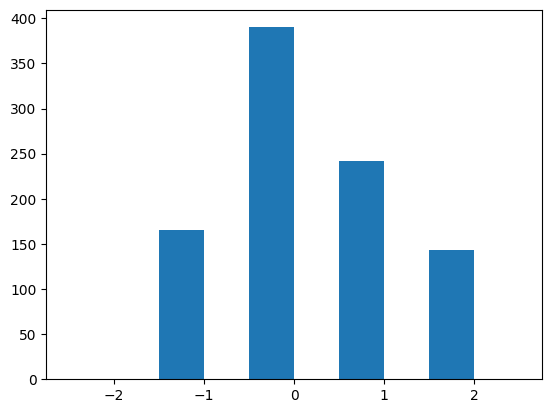

In [ ]:
Y_pre=model.predict(TX_testAll)
diff=Y_pre[0]-(Y_test)
test_accuracy=np.mean((diff<1) & (diff >-1))
print('mean=',np.mean(diff))
print('median=',np.median(diff))
print('around_val_accuracy=',test_accuracy*100,"%")
plt.hist(diff,density=False,bins=[-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5])
plt.show()

The model performs very similarly on the TestSet as on the ValSet, which, from my perspective, shows that it has good generalization ability.

# 9 Conclusions
The model performance is not very good but basically acceptable for me. To approve it, I get following ideas:  
**1)** the current pipeline can't balance features from different sources well. The features from the Ingredients and Names may be too much more than others. It may be resolvable by designing more reasonable and comprehensive neural network architecture or import more different models into the system.  
**2)** the data source of for our dataset is complex, we may be missing some critical predictors (like the homeland of the submitter, their age, their living habits and so on)  
**3)** the features we extracted may not be the best ones. There should be a better method to extract information from long-text features, likr the Ingredients and Names. And the pictures may contains more hidden information that can be extracted somehow.